<a href="https://colab.research.google.com/github/nmningmei/preprocessing_pipelines/blob/master/EEG_preprocessing_and_concatenate_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Something you have to do everytime you use colab and the data are in your google drive


In [0]:
!pip install -U mne
!pip install -U autoreject

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
eeg_ids = {1:'https://drive.google.com/open?id=1KRAtEBkuwqFloxxB-UgmpgrdOihHMFUo'.split('id=')[-1],
           2:'https://drive.google.com/open?id=1w5bqX4KkFZMFOVZkxFl8svP6ASCfPPx_'.split('id=')[-1],
           3:'https://drive.google.com/open?id=1jz2e8i_yi6vHqycf_3fe4w89UvARVZar'.split('id=')[-1],
           #4:'https://drive.google.com/open?id=1xuOURk9L0nSjQ00JCg8W_19o4twQ_hbP'.split('id=')[-1],
          }
vmrk_ids = {1:'https://drive.google.com/open?id=1_1FfJdY4UPNe-GdYPCZBFwVUJQxrUuEJ'.split('id=')[-1],
            2:'https://drive.google.com/open?id=1JZiQ5NmTAtn7Fj3urLmEJNYL9RGWzcIs'.split('id=')[-1],
            3:'https://drive.google.com/open?id=1hB9Pyqt-Dx6EoyyAIgkCaeBZEMeQ2aqx'.split('id=')[-1],
            #4:'https://drive.google.com/open?id=1RiBZ97jxVxI6GrpoVpo1nAUikPA9B1t4'.split('id=')[-1],
           }
vhdr_ids = {1:'https://drive.google.com/open?id=1uOkwHe-dySh5chqCyppKxrzwb0fV2x17'.split('id=')[-1],
            2:'https://drive.google.com/open?id=17kgiU8HDIIKH2-YYeTTwXrAMSR2pivlh'.split('id=')[-1],
            3:'https://drive.google.com/open?id=1D90dGVYZD6FKmh18bHQN-xgyLUtjsI6C'.split('id=')[-1],
            #4:'https://drive.google.com/open?id=1IBVNlU0NtAdSZnbqWLQL8Ffvk8i-Gm3q'.split('id=')[-1],
           }



    100% |████████████████████████████████| 6.2MB 4.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/39/f9/f5/3e2fdef321f8e1f64061730c8ba2c81ad55c4b1b860b29d2dd
Successfully built mne
    100% |████████████████████████████████| 51kB 2.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/10/a0/f0/ca66d3b5b0501f1cb40e656cac6a9101ef3c0bb33845943e5a
Successfully built autoreject
    100% |████████████████████████████████| 993kB 18.9MB/s 


# Download data from Google Drive to colab

In [0]:
for key,value in eeg_ids.items():
    downloaded = drive.CreateFile({'id':value})
    downloaded.GetContentFile(f'Patxi_sesion{key}.eeg')
for key,value in vmrk_ids.items():
    downloaded = drive.CreateFile({'id':value})
    downloaded.GetContentFile(f'Patxi_sesion{key}.vmrk')
for key,value in vhdr_ids.items():
    downloaded = drive.CreateFile({'id':value})
    downloaded.GetContentFile(f'Patxi_sesion{key}.vhdr')
        

In [0]:
from glob import glob
import mne
import numpy as np
#from autoreject import (AutoReject,get_rejection_threshold)

# We will use the function defined below for automatic preprocessing. Most of the hyperparameters are set based on the 64-channel system, and 4 of them are used as the EOG channels. The time period of interest is -0.15 seconds prior to the onset of the probe and 1 second after the onset of the probe. 

[pipeline reference, page 7](https://www.biorxiv.org/content/biorxiv/early/2019/01/11/518662.full.pdf)

In [0]:
def preprocessing_conscious(
                  raw,events,
                  n_interpolates = np.arange(1,32,4),
                  consensus_pers = np.linspace(0,1.0,11),
                  event_id = {'living':1,'nonliving':2},
                  tmin = -0.15,
                  tmax = 0.15 * 6,
                  high_pass = 0.1,
                  low_pass = 50,
                  notch_filter = 50,
                  fix = True,):
    """
    Preprocessing pipeline for conscious trials
    
    Inputs
    -------------------
    raw: MNE Raw object, contineous EEG raw data
    events: Numpy array with 3 columns, where the first column indicates time and the last column indicates event code
    n_interpolates: list of values 1 <= N <= max number of channels
    consensus_pers: ?? autoreject hyperparameter search grid
    event_id: MNE argument, to control for epochs
    tmin: first time stamp of the epoch
    tmax: last time stamp of the epoch
    high_pass: low cutoff of the bandpass filter
    low_pass: high cutoff of the bandpass filter
    notch_filter: frequency of the notch filter, 60 in US and 50 in Europe
    fix : when "True", apply autoReject algorithm to remove artifacts that was not identifed in the ICA procedure
    Output
    -------------------
    Epochs: MNE Epochs object, segmented and cleaned EEG data (n_trials x n_channels x n_times)
    """
    # preprocessing: https://www.biorxiv.org/content/10.1101/518662v1
    """
    0. re-reference - explicitly
    """
    raw_ref ,_  = mne.set_eeg_reference(raw,
                                       ref_channels     = 'average',
                                       projection       = True,)
    raw_ref.apply_proj() # it might tell you it already has been re-referenced, but do it anyway
    try: # cut the portion of the EEG data that is not very useful: before and after the experiment
        raw_ref = raw_ref.crop(events[0][0]     - 10,
                               events[-1][0]    + 10)
    except:
        pass
    """
    1. bandpass filter between 0.1 Hz and 50 Hz 
        by a 4th order zero-phase Butterworth filter
    """
    # everytime before filtering, explicitly pick the type of channels you want
    # to perform the filters
    picks = mne.pick_types(raw_ref.info,
                           meg = False, # No MEG
                           eeg = True,  # YES EEG
                           eog = True,  # YES EOG
                           )
    # regardless the bandpass filtering later, we should always filter
    # for wire artifacts and their oscillations
    raw_ref.notch_filter(np.arange(notch_filter,241,notch_filter),
                         picks = picks)
    # high pass filtering
    picks = mne.pick_types(raw_ref.info,
                           meg = False, # No MEG
                           eeg = True,  # YES EEG
                           eog = False, # No EOG
                           )
    raw_ref.filter(high_pass,
                   None,                         # no low pass filter because we want to have the ICA to identify some of the high frequency components
                   picks            = picks,
                   filter_length    = 'auto',    # the filter length is chosen based on the size of the transition regions (6.6 times the reciprocal of the shortest transition band for fir_window=’hamming’ and fir_design=”firwin2”, and half that for “firwin”)
                   method           = 'fir',     # overlap-add FIR filtering
                   phase            = 'zero',    # the delay of this filter is compensated for
                   fir_window       = 'hamming', # The window to use in FIR design
                   fir_design       = 'firwin2',  # a time-domain design technique that generally gives improved attenuation using fewer samples than “firwin2”
                   )
    
    """
    2. epoch the data
    """
    picks       = mne.pick_types(raw_ref.info,
                           eeg      = True, # YES EEG
                           eog      = True, # YES EOG
                           )
    epochs      = mne.Epochs(raw_ref,
                             events,    # numpy array
                             event_id,  # dictionary
                        tmin        = tmin,
                        tmax        = tmax,
                        baseline    = (tmin,0), # range of time for computing the mean references for each channel and subtract these values from all the time points per channel
                        picks       = picks,
                        detrend     = 1, # linear detrend
                        preload     = True # must be true if we want to do further processing
                        )
    
    """
    3. ica on epoch data
    """
    # calculate the noise covariance of the epochs
    noise_cov   = mne.compute_covariance(epochs,
                                         tmin                   = tmin,
                                         tmax                   = tmax,
                                         method                 = 'empirical',
                                         rank                   = None,)
    # define an ica function
    ica         = mne.preprocessing.ICA(n_components            = .99,
                                        n_pca_components        = .99,
                                        max_pca_components      = None,
                                        method                  = 'extended-infomax',
                                        max_iter                = int(3e3),
                                        noise_cov               = noise_cov,
                                        random_state            = 12345,)
    # search for a global rejection threshold globally
    reject      = get_rejection_threshold(epochs,
                                          decim = 2,
                                          random_state = 12345)
    picks       = mne.pick_types(epochs.info,
                                 eeg = True, # YES EEG
                                 eog = False # NO EOG
                                 ) 
    ica.fit(epochs,
            picks   = picks,
            start   = tmin,
            stop    = tmax,
            reject  = reject, # if some data in a window has values that exceed the rejection threshold, this window will be ignored when computing the ICA
            decim   = 3,
            tstep   = 1. # Length of data chunks for artifact rejection in seconds. It only applies if inst is of type Raw.
            )
    # search for artificial ICAs automatically
    # most of these hyperparameters were used in a unrelated published study
    ica.detect_artifacts(epochs,
                         eog_ch         = ['FT9','FT10','TP9','TP10'],
                         eog_criterion  = 0.4, # arbitary choice
                         skew_criterion = 2,   # arbitary choice
                         kurt_criterion = 2,   # arbitary choice
                         var_criterion  = 2,   # arbitary choice
                         )
    # explicitly search for eog ICAs 
    eog_idx,scores = ica.find_bads_eog(raw_ref,
                            start       = tmin,
                            stop        = tmax,
                            l_freq      = 1,
                            h_freq      = 50,
                            )
    ica.exclude += eog_idx
    
    ica_epochs  = ica.apply(epochs,
                             exclude    = ica.exclude,
                             )
    if fix:
        """
        4. apply autoreject
        """
        picks       = mne.pick_types(ica_epochs.info,
                               eeg          = True, # YES EEG
                               eog          = False # NO EOG
                               )
        ar          = AutoReject(
                        n_interpolate       = n_interpolates,
                        consensus           = consensus_pers,
                        thresh_method       = 'bayesian_optimization',
                        picks               = picks,
                        random_state        = 12345,
                        n_jobs              = 1,
                        )
        epochs_clean = ar.fit_transform(ica_epochs)
        
        epochs_clean.pick_types(eeg = True,eog = False) # filter out EOG channels
        # now apply the low pass filter
        return epochs_clean.filter(
                   None,
                   low_pass,
                   filter_length    = 'auto',    # the filter length is chosen based on the size of the transition regions (6.6 times the reciprocal of the shortest transition band for fir_window=’hamming’ and fir_design=”firwin2”, and half that for “firwin”)
                   method           = 'fir',     # overlap-add FIR filtering
                   phase            = 'zero',    # the delay of this filter is compensated for
                   fir_window       = 'hamming', # The window to use in FIR design
                   fir_design       = 'firwin2',  # a time-domain design technique that generally gives improved attenuation using fewer samples than “firwin2”
                   )
    else:
        return ica_epochs.pick_types(eeg = True,eog = False).filter(
                   None,
                   low_pass,
                   filter_length    = 'auto',    # the filter length is chosen based on the size of the transition regions (6.6 times the reciprocal of the shortest transition band for fir_window=’hamming’ and fir_design=”firwin2”, and half that for “firwin”)
                   method           = 'fir',     # overlap-add FIR filtering
                   phase            = 'zero',    # the delay of this filter is compensated for
                   fir_window       = 'hamming', # The window to use in FIR design
                   fir_design       = 'firwin2',  # a time-domain design technique that generally gives improved attenuation using fewer samples than “firwin2”
                   ) # filter out EOG channels

Extracting parameters from Patxi_sesion3.vhdr...
Setting channel info structure...
Reading 0 ... 576779  =      0.000 ...   576.779 secs...
Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S  5']


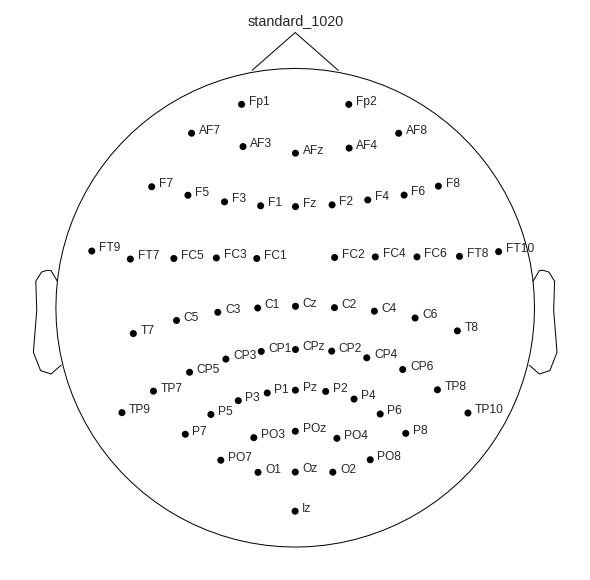

300 events found
Event IDs: [1 2 3 4 5 6 7 8]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-stop filter
Filter length of 6601 samples (6.601 sec) selected


KeyboardInterrupt: ignored

In [0]:
epochs_concat = []
working_data = glob('*.vhdr')
for eeg_file in working_data:
    # load the data with vhdr, aka header file
    raw = mne.io.read_raw_brainvision(eeg_file,preload=True,stim_channel=True)
    # if we work with only 32 channels, we need to rename them in a specific order
    channel_names = '''Fp1 Fz F3 F7 FT9 FC5 FC1 C3 T7 TP9 CP5 CP1 Pz P3 P7 O1 Oz O2 P4 P8 TP10 CP6 CP2 Cz C4 T8 FT10 FC6 FC2 F4 F8 Fp2 AF7 AF3 AFz F1 F5 FT7 FC3 C1 C5 TP7 CP3 P1 P5 PO7 PO3 POz PO4 PO8 P6 P2 CPz CP4 TP8 C6 C2 FC4 FT8 F6 AF8 AF4 F2 Iz'''
    channel_names = channel_names.split(' ')
    channel_names.insert(65,'STI 014')
    channel_map = {a:b for a,b in zip(raw.ch_names,channel_names)}
    # change the existed channel names
    raw.rename_channels(channel_map)
    # read standard montage - montage is important for visualization
    montage = mne.channels.read_montage('standard_1020',ch_names=raw.ch_names);montage.plot()
    raw.set_montage(montage)
    # set the EOG channels
    channel_types = {'FT9':'eog','FT10':'eog','TP9':'eog','TP10':'eog'}
    raw.set_channel_types(channel_types)
    # get events
    events = mne.find_events(raw,stim_channel='STI 014')
    decode_events = events[events[:,-1] < 3]
    respond_events = events[np.logical_and(2 < events[:,-1], events[:,-1] < 5)] 
    visible_events = events[4 < events[:,-1]]
    recode_events = decode_events.copy()
    recode_events[:,-1] = decode_events[:,-1] * 10 + visible_events[:,-1]
    
    event_ids = {}
    decode_ids = {'living':1,'nonliving':2}
    respond_ids = {'living':3,'nonliving':4}
    visible_ids = {'unconscious':5,
                   'see_unknown':6,
                   'see_maybe':7,
                   'conscious':8,}
    unique_event_id = {f'{a_key} {b_key}':10*a+b for a_key,a in decode_ids.items() for b_key,b in visible_ids.items()}
    
    epochs = preprocessing_conscious(raw,recode_events,
                                     event_id = unique_event_id,
                                     n_interpolates = np.arange(1,32,4),
                                     consensus_pers = np.linspace(0,1.0,11),
                                     tmin = -0.15,
                                     tmax = 0.15 + 0.15 * 5 + 0.15,
                                     high_pass = 0.1,
                                     low_pass = 50)
    
    epochs_concat.append(epochs)

300 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


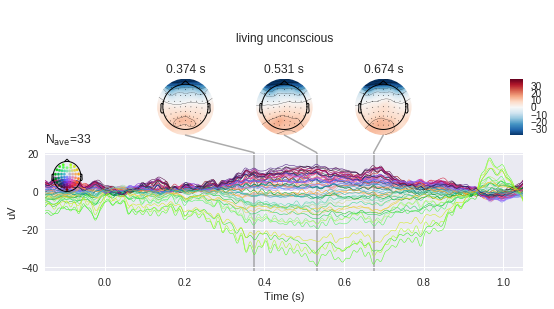

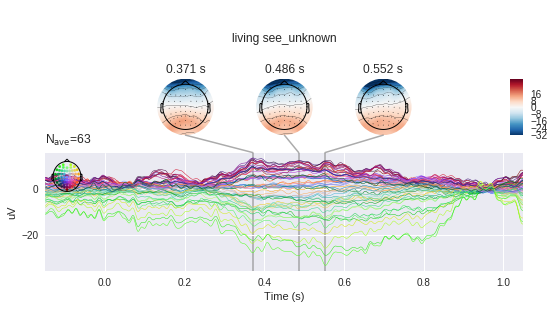

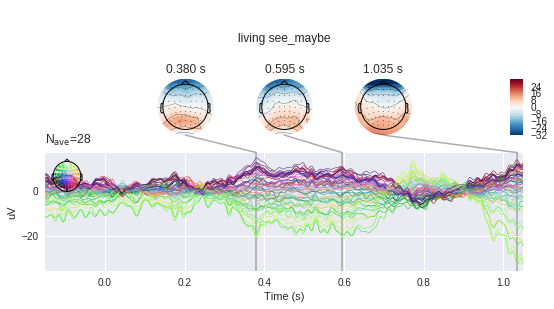

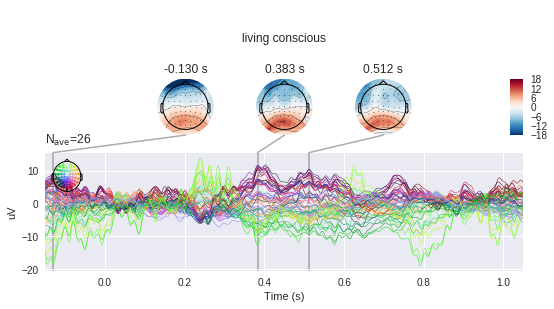

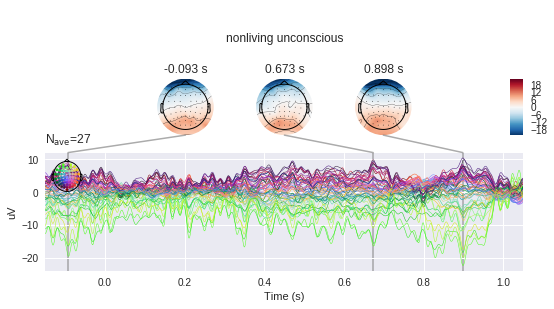

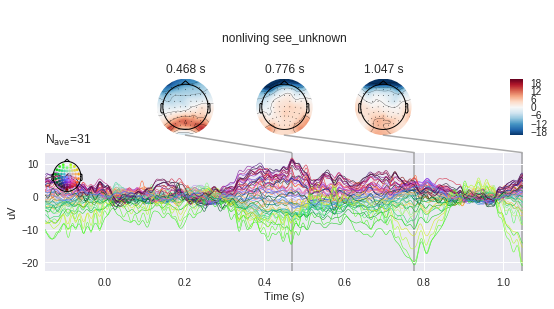

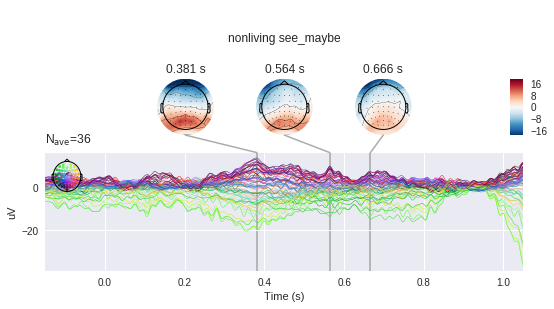

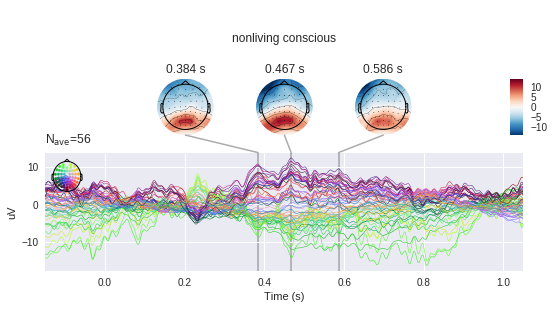

In [0]:
epochs = mne.concatenate_epochs(epochs_concat)

for key in epochs.event_id.keys():
    evoked = epochs[key].average()
    evoked.plot_joint(title = key)

In [0]:
epochs.save('clean-epo.fif')